## Multi-layer Perceptron Implementation from Scratch

In [1]:
import numpy as np

class Perceptron:    
    def fit(self, X, y, n_iter=100):
        
        n_samples = X.shape[0]
        n_features = X.shape[1]
        
        # Add 1 for the bias term
        self.weights = np.zeros((n_features+1,))
        
        # Add column of 1s
        X = np.concatenate([X, np.ones((n_samples, 1))], axis=1)
        
        for i in range(n_iter):
            for j in range(n_samples):
                if y[j]*np.dot(self.weights, X[j, :]) <= 0:
                    self.weights += y[j]*X[j, :]
    
    def predict(self, X):
        if not hasattr(self, 'weights'):
            print('The model is not trained yet!')
            return
        
        n_samples = X.shape[0]
        # Add column of 1s
        X = np.concatenate([X, np.ones((n_samples, 1))], axis=1)
        y = np.matmul(X, self.weights)
        y = np.vectorize(lambda val: 1 if val > 0 else -1)(y)
        
        return y
    
    def score(self, X, y):
        pred_y = self.predict(X)
        
        return np.mean(y == pred_y)

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets

def plot_data_points(ax, X, y):
    neg_class = (y == -1)
    pos_class = (y == 1)
    ax.scatter(X[neg_class, 0], X[neg_class, 1])
    ax.scatter(X[pos_class, 0], X[pos_class, 1])

def plot_decision_boundary(ax, clf, X, p):
    X_cpy = X.copy()
    margin = 0.5
    x_min = np.min(X_cpy[:, 0])-margin
    x_max = np.max(X_cpy[:, 0])+margin
    y_min = np.min(X_cpy[:, 1])-margin
    y_max = np.max(X_cpy[:, 1])+margin
    n = 1000
    x = np.linspace(x_min, x_max, num=n)
    y = np.linspace(y_min, y_max, num=n)
    x, y = np.meshgrid(x, y)
    X_cpy = np.stack([x.reshape((n*n,)), y.reshape((n*n,))], axis=1)
    X_cpy = polynomial_features(X_cpy, p)
    z = clf.predict(X_cpy)
    z = z.reshape((n, n))
    ax.contour(x, y, z, levels=[0])

def polynom(indices_list, indices, a, b, p):
    indices = [*indices]
    if p == 0:
        indices_list.append(indices)
        return
    for i in range(a, b):
        indices.append(i)
        polynom(indices_list, indices, i, b, p-1)
        indices = indices[0:-1]

def polynomial_features(X: np.ndarray, p) -> np.ndarray:
    n, d = X.shape
    features = []
    for i in range(1, p+1):
        l = []
        polynom(l, [], 0, d, i)
        for indices in l:
            x = np.ones((n,))
            for idx in indices:
                x = x * X[:, idx]
            features.append(x)
    return np.stack(features, axis=1)

def anim_fig(weights, X, y, X_train, y_train, X_test, y_test, out_folder, p, n_iter, i, j, n_samples, iteration_level):
    clf = Perceptron()
    clf.weights = weights

    plt.clf()
    fig, (ax_train, ax_test) = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(16,6))
    
    if iteration_level:
        plot_data_points(X_train, y_train)
    else:
        mask = np.ones((n_samples,), dtype=bool)
        mask[j] = False
        plot_data_points(ax_train, X_train[mask, :], y_train[mask])
        ax_train.scatter(X_train[j, 0], X_train[j, 1], c='lime')
    
    plot_data_points(ax_test, X_test, y_test)

    plot_decision_boundary(ax_train, clf, X, p)
    plot_decision_boundary(ax_test, clf, X, p)

    ax_train.set_title('Train')
    ax_test.set_title('Test')

    if iteration_level:
        fig.suptitle(f'Iteration: {i+1}/{n_iter}', fontsize=14)
    else:
        fig.suptitle(f'Iteration: {i+1}/{n_iter}; Point: {j+1}/{n_samples}', fontsize=14)
    k = i if iteration_level else i*n_samples+j
    plt.savefig(f'{out_folder}/frame{k}.png')
    plt.close(fig)

def perceptron_anim(X, y, X_train, y_train, X_test, y_test, out_folder, iteration_level, p=1, n_iter=100):

    n_samples = X_train.shape[0]
    n_features = X_train.shape[1]

    weights = np.zeros((n_features+1,))

    X_train = np.concatenate([X_train, np.ones((n_samples, 1))], axis=1)

    for i in range(n_iter):
        for j in range(n_samples):
            if y_train[j]*np.dot(weights, X_train[j, :]) <= 0:
                weights += y_train[j]*X_train[j, :]
                
            if not iteration_level:
                anim_fig(weights, X, y, X_train, y_train, X_test, y_test, out_folder, p, n_iter, i, j, n_samples, iteration_level)
        if iteration_level:
            anim_fig(weights, X, y, X_train, y_train, X_test, y_test, out_folder, p, n_iter, i, j, n_samples, iteration_level)


#### EXAMPLE 1: Data (Linear Boundary but noisy)

In [3]:
X, y = datasets.make_classification(n_features=2, n_classes=2, n_samples=200, n_redundant=0, n_clusters_per_class=1)
y = np.vectorize(lambda v: -1 if v == 0 else 1)(y)

np.save('X_data.npy', X)
np.save('y_data.npy', y)

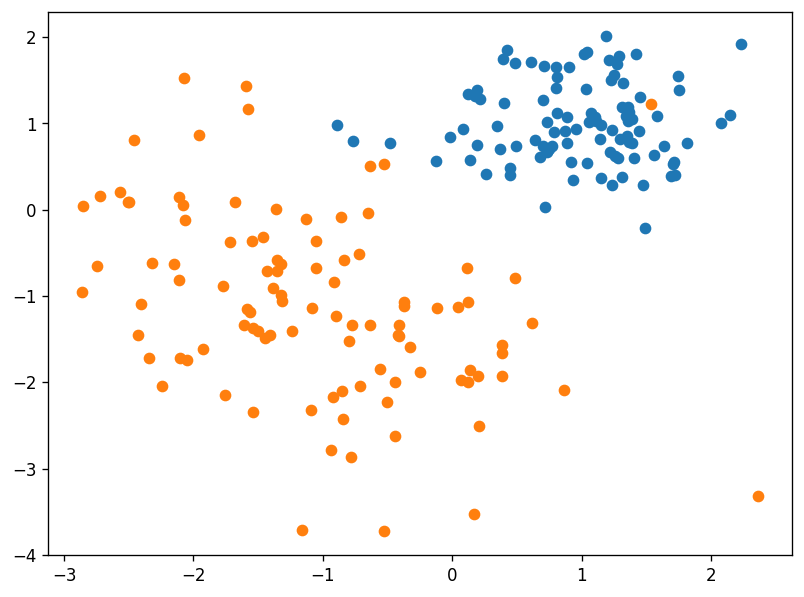

In [4]:
# Loading the data
X = np.load('X_data.npy')
y = np.load('y_data.npy')

X = polynomial_features(X, 2)

# Plot the data points distribution
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(8,6))
plot_data_points(ax, X, y)
plt.show()

#### Perceptron training

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

perceptron = Perceptron()
perceptron.fit(X_train, y_train)

print("The perceptron algorithm got",(perceptron.score(X_test, y_test))*100,"% test accuracy.") 

The perceptron algorithm got 94.0 % test accuracy.


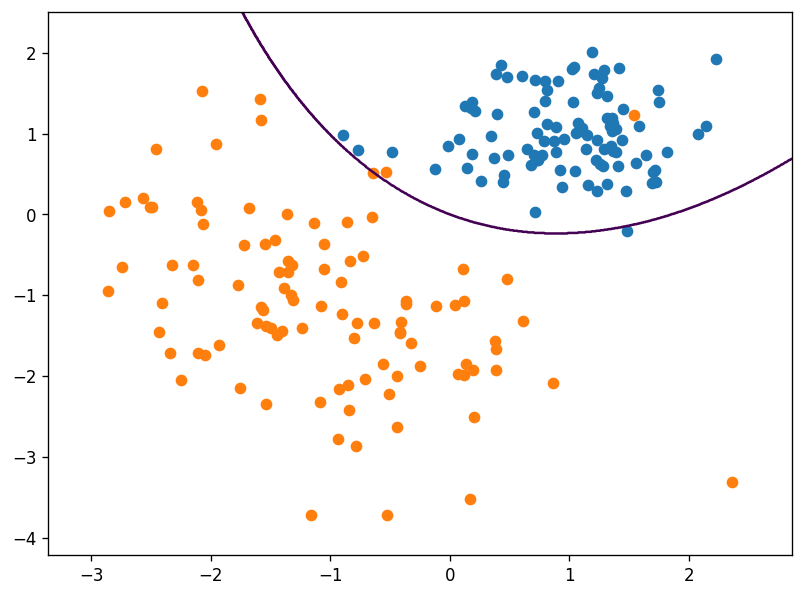

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(8,6))
plot_data_points(ax,X, y)
plot_decision_boundary(ax, perceptron, X, 2)
plt.show()


#### EXAMPLE 2: Data (Not linear at all)

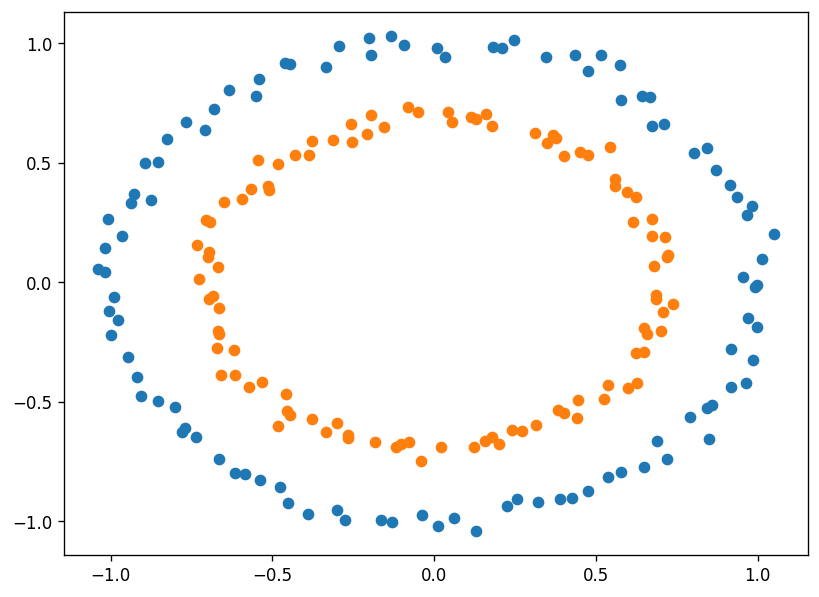

In [7]:
#Data Generation(non-linear)
X, y = datasets.make_circles(n_samples=200, noise=0.03, factor=0.7)
y = np.vectorize(lambda v: -1 if v == 0 else 1)(y)

#Saving the two datasets
np.save('X_circles.npy', X)
np.save('y_circles.npy', y)

#Loading
X = np.load('X_circles.npy')
y = np.load('y_circles.npy')

X = polynomial_features(X, 2)

#plotting the data
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(8,6))
plot_data_points(ax, X, y)
plt.show()

#### Perceptron training

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
print("Well, the perceptron algorithm attempts to find a line that best separates them.\nIn this example, our perceptron got a probability of ",perceptron.score(X_test, y_test))
print("\n")
print("Let's visualize the separating curve;")

Well, the perceptron algorithm attempts to find a line that best separates them.
In this example, our perceptron got a probability of  1.0


Let's visualize the separating curve;


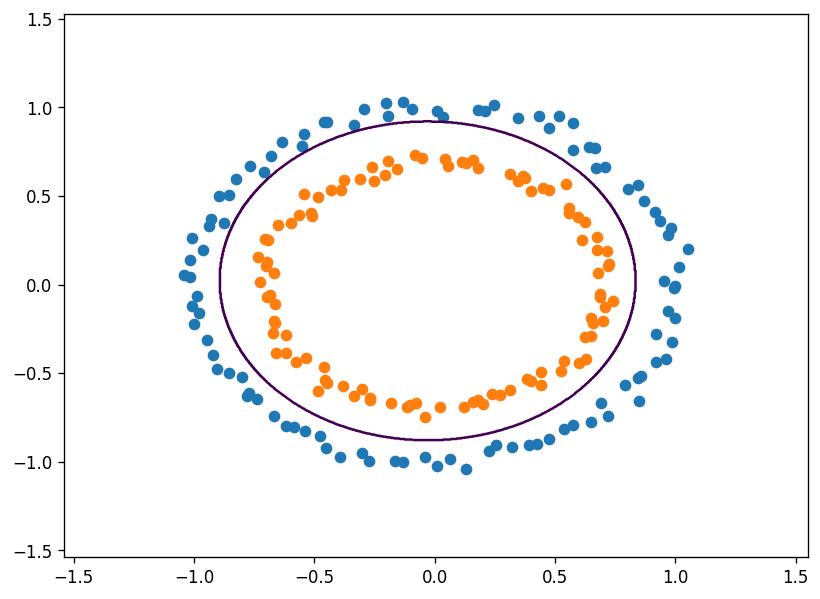

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(8,6))
plot_data_points(ax, X, y)
plot_decision_boundary(ax, perceptron, X, 2)
plt.show()